In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
import shutil
import os

In [3]:
# load from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls /content/drive/MyDrive/content

archive.zip


In [5]:
!unzip /content/drive/MyDrive/content/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: landscape Images/gray/2914.jpg  
  inflating: landscape Images/gray/2915.jpg  
  inflating: landscape Images/gray/2916.jpg  
  inflating: landscape Images/gray/2917.jpg  
  inflating: landscape Images/gray/2918.jpg  
  inflating: landscape Images/gray/2919.jpg  
  inflating: landscape Images/gray/292.jpg  
  inflating: landscape Images/gray/2920.jpg  
  inflating: landscape Images/gray/2921.jpg  
  inflating: landscape Images/gray/2922.jpg  
  inflating: landscape Images/gray/2923.jpg  
  inflating: landscape Images/gray/2924.jpg  
  inflating: landscape Images/gray/2925.jpg  
  inflating: landscape Images/gray/2926.jpg  
  inflating: landscape Images/gray/2927.jpg  
  inflating: landscape Images/gray/2928.jpg  
  inflating: landscape Images/gray/2929.jpg  
  inflating: landscape Images/gray/293.jpg  
  inflating: landscape Images/gray/2930.jpg  
  inflating: landscape Images/gray/2931.jpg  
  inflating: landscape Images/g

In [6]:
len(os.listdir('/content/landscape Images/color'))

7129

In [7]:
TRAIN_ROOT_DIR = '/content/landscape Images/color'
DEST = '/content/train/images'

if not os.path.exists(DEST):
  os.makedirs(DEST)

for img in os.listdir(os.path.join(TRAIN_ROOT_DIR)):
  ORG = os.path.join(TRAIN_ROOT_DIR, img)
  print(ORG)
  try:
    #imread(ORG)
    shutil.copy(ORG, DEST)
  except:
    print(f"the image at {ORG} cannot be used")


Streaming output truncated to the last 5000 lines.
/content/landscape Images/color/737.jpg
/content/landscape Images/color/1139.jpg
/content/landscape Images/color/4208.jpg
/content/landscape Images/color/2813.jpg
/content/landscape Images/color/498.jpg
/content/landscape Images/color/6403.jpg
/content/landscape Images/color/7120.jpg
/content/landscape Images/color/6359.jpg
/content/landscape Images/color/6795.jpg
/content/landscape Images/color/1496.jpg
/content/landscape Images/color/2254.jpg
/content/landscape Images/color/1347.jpg
/content/landscape Images/color/6787.jpg
/content/landscape Images/color/6535.jpg
/content/landscape Images/color/1003.jpg
/content/landscape Images/color/5968.jpg
/content/landscape Images/color/685.jpg
/content/landscape Images/color/2470.jpg
/content/landscape Images/color/4810.jpg
/content/landscape Images/color/3848.jpg
/content/landscape Images/color/5150.jpg
/content/landscape Images/color/2864.jpg
/content/landscape Images/color/2645.jpg
/content/

In [8]:
len(os.listdir('/content/train/images'))

7129

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   featurewise_center=False,
                                   rotation_range=40,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   #featurewise_std_normalization=False,
                                   )

In [4]:
train = train_datagen.flow_from_directory('/content/train',
                                          target_size=(256, 256),
                                          batch_size=1000,
                                          shuffle=True)

Found 7129 images belonging to 1 classes.


In [5]:
t_img, label = next(train) # Use next(train) instead of train.next()

In [6]:
def plotImage(img_arr, label):
  plt.figure(figsize=(5, 5))
  for im, l in zip(img_arr, label):
    plt.imshow(im)
    plt.title(l)
    plt.axis('off')
    plt.show()


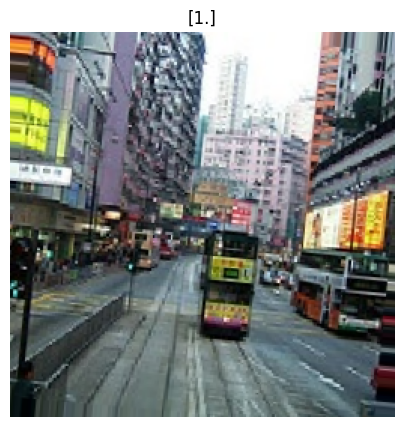

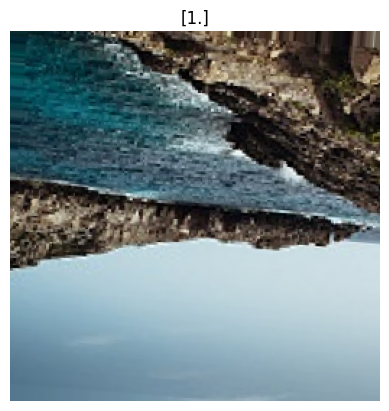

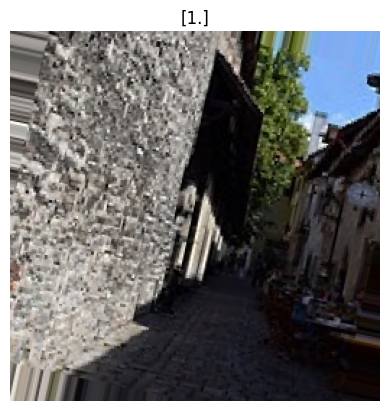

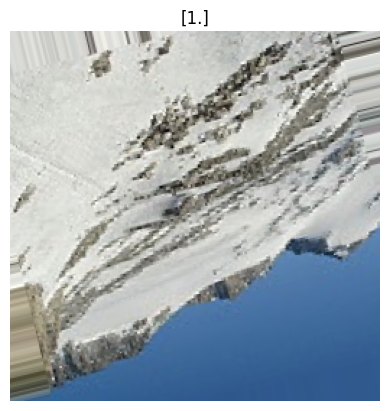

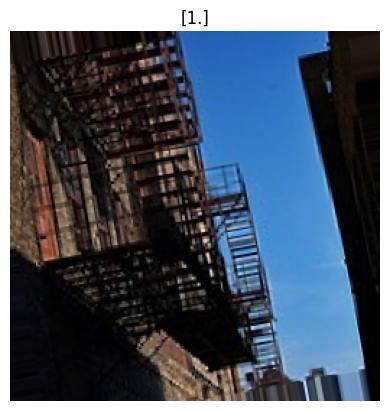

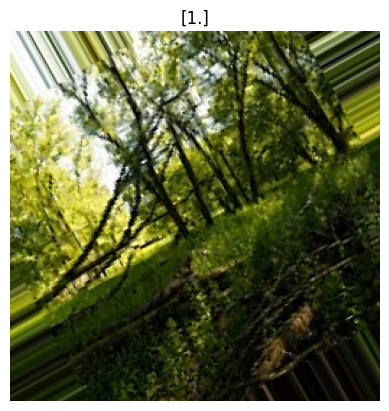

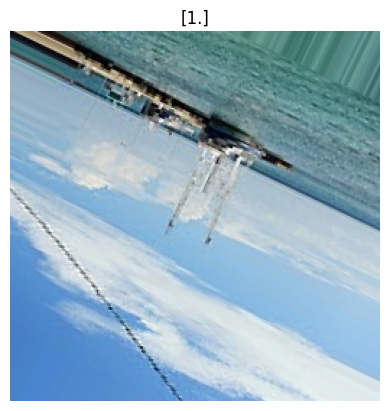

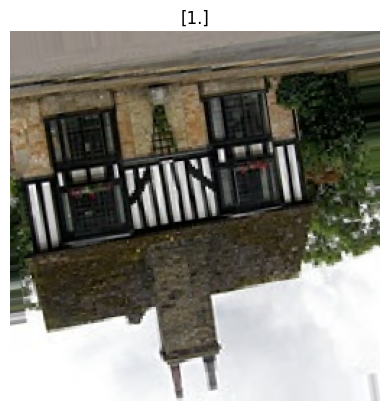

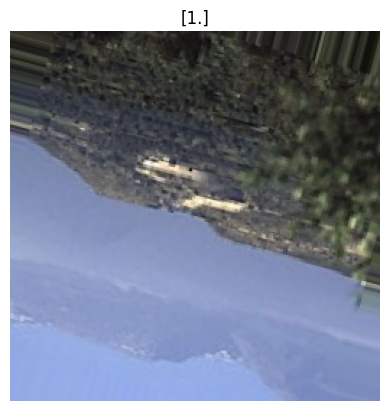

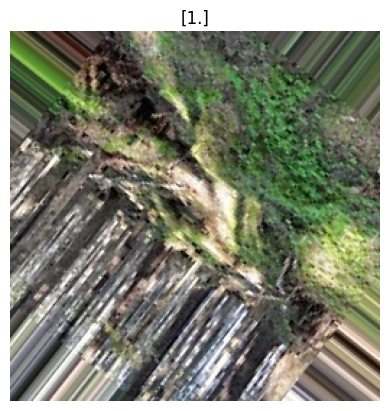

In [9]:
plotImage(t_img[:10], label[:10])

In [10]:

t_img[:10].shape

(10, 256, 256, 3)

In [11]:
x = []  # bw
y = []  # color

In [12]:
for img in t_img:
  try:
    lab = rgb2lab(img)
    x.append(lab[:,:,0])
    y.append(lab[:,:,1:] / 128)
  except:
    print('error')

In [13]:
x_train = np.array(x)
x_train = np.expand_dims(x_train, axis=len(x_train.shape))
y_train = np.array(y)

In [14]:
x_train.shape, y_train.shape

((1000, 256, 256, 1), (1000, 256, 256, 2))

In [15]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

In [45]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, LeakyReLU, Dropout, BatchNormalization, Concatenate
from keras.models import Sequential, Model
from keras.optimizers import Adam

# Using a functional API for skip connections
inputs = Input(shape=(256, 256, 1))

# Encoder
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(inputs)
bn1 = BatchNormalization()(conv1)
drop1 = Dropout(0.1)(bn1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(drop1)
bn2 = BatchNormalization()(conv2)
drop2 = Dropout(0.2)(bn2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(drop2)
bn3 = BatchNormalization()(conv3)
drop3 = Dropout(0.2)(bn3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(drop3)
bn4 = BatchNormalization()(conv4)
drop4 = Dropout(0.3)(bn4)

conv5 = Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(drop4)
bn5 = BatchNormalization()(conv5)
drop5 = Dropout(0.3)(bn5)

# Middle
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(drop5)
bn6 = BatchNormalization()(conv6)
drop6 = Dropout(0.4)(bn6)

conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(drop6)
bn7 = BatchNormalization()(conv7)
drop7 = Dropout(0.4)(bn7)

# Decoder with skip connections
conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(drop7)
bn8 = BatchNormalization()(conv8)
drop8 = Dropout(0.3)(bn8)
# Add skip connection from conv5/bn5
merge1 = Concatenate()([drop8, bn5])

conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge1)
bn9 = BatchNormalization()(conv9)
drop9 = Dropout(0.3)(bn9)
up1 = UpSampling2D((2, 2))(drop9)
# Add skip connection from conv3/bn3
merge2 = Concatenate()([up1, bn3])

conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge2)
bn10 = BatchNormalization()(conv10)
drop10 = Dropout(0.2)(bn10)
up2 = UpSampling2D((2, 2))(drop10)
# Add skip connection from conv1/bn1
merge3 = Concatenate()([up2, bn1])

conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge3)
bn11 = BatchNormalization()(conv11)
drop11 = Dropout(0.1)(bn11)

conv12 = Conv2D(16, (3, 3), activation='relu', padding='same')(drop11)
bn12 = BatchNormalization()(conv12)

# Final output
output = Conv2D(2, (3, 3), activation=LeakyReLU(alpha=0.1), padding='same')(bn12)
up3 = UpSampling2D((2, 2))(output)

# Create model
model = Model(inputs=inputs, outputs=up3)

# Compile with a more stable optimizer configuration
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

model.summary()

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 128, 128,  │        640 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 128, 128,  │     73,856 │ dropout_11[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 64, 64,    │    147,584 │ dropout_12[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 64, 64,    │    295,168 │ dropout_13[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 32, 32,    │    590,080 │ dropout_14[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ dropout_15[0][0]

 Total params: 6,615,890 (25.24 MB)

 Trainable params: 6,611,186 (25.22 MB)

 Non-trainable params: 4,704 (18.38 KB)

In [46]:
model.compile(optimizer='adam', metrics=['acc'], loss='mse')

In [47]:
his = model.fit(x_train, y_train, epochs=50, batch_size=32, steps_per_epoch=x_train.shape[0] // 32, verbose=True)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 46s 421ms/step - acc: 0.5052 - loss: 0.2336
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 732us/step - acc: 0.5505 - loss: 0.0189
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 418ms/step - acc: 0.5335 - loss: 0.0192
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - acc: 0.5169 - loss: 0.0190
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 422ms/step - acc: 0.5470 - loss: 0.0147
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.5463 - loss: 0.0117  
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 427ms/step - acc: 0.5596 - loss: 0.0136
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.5990 - loss: 0.0122  
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 417ms/step - acc: 0.5799 - loss: 0.0127
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - acc: 0.6388 - loss: 0.0128
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 421ms/step - acc: 0.5896 - loss: 0.0120
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - acc: 0.5817 - loss: 0.0100
Epoch 13/50
31/31 

In [48]:
model.save("./bestmodel.h5")

In [49]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img # Import img_to_array and load_img
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow # Import imshow

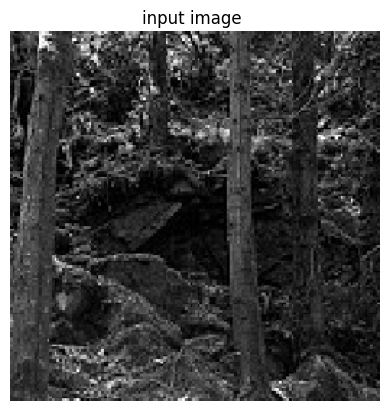

In [65]:
img1_color = []
path = "/content/landscape Images/gray/200.jpg"

img = img_to_array(load_img(path, target_size=(256, 256, 3))) / 255
plt.title("input image ")
imshow(img)
plt.axis('off')
plt.show()

In [66]:
img1_color.append(img)
img1_color = rgb2lab(img1_color)[:, :, :, 0]

img1_color = img1_color.reshape(img1_color.shape + (1,))

In [67]:
output1 = model.predict(img1_color)
output1 = output1 * 128

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [68]:
result = np.zeros((256, 256, 3))
result[:, :, 0] = img1_color[0][:, :, 0]
result[:, :, 1:] = output1[0]

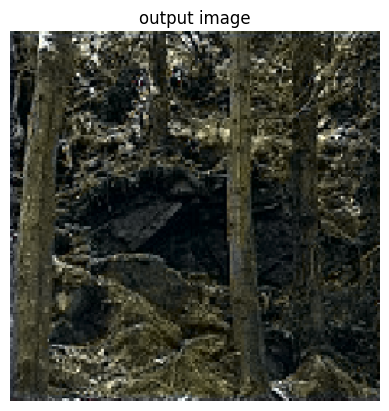

In [69]:
imshow(lab2rgb(result))
plt.title("output image")
plt.axis('off')
plt.show()